In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import string
import re
import unicodedata

# General BERT vocab stats

In [2]:
bert_fn = os.environ["HOME"] + "/resources/bert/bert_multi_vocab"

if not os.path.exists(bert_fn):
    bert_fn = os.environ["HOME"] + "/.pytorch_pretrained_bert/96435fa287fbf7e469185f1062386e05a075cadbf6838b" \
        "74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729"
    
bert_vocab = pd.read_table(bert_fn, names=["token"], quoting=3, na_filter=False)

bert_vocab.shape

(119547, 1)

In [3]:
bert_vocab['is_reserved'] = ((bert_vocab.token.str[0]=="[") & (bert_vocab.token.str[-1]=="]") |
    (bert_vocab.token.str[0]=="<") & (bert_vocab.token.str[-1]==">"))
bert_vocab['is_continuation'] = bert_vocab.token.str.startswith('##')
bert_vocab[['is_reserved', 'is_continuation']].agg(['sum', 'mean'])

,is_reserved,is_continuation
sum,106.000000,43606.00000
mean,0.000887,0.36476


In [4]:
bert_vocab['token_len'] = bert_vocab.token.str.lstrip("##").str.len()

In [5]:
if not os.path.exists("fig"):
    os.makedirs("fig")

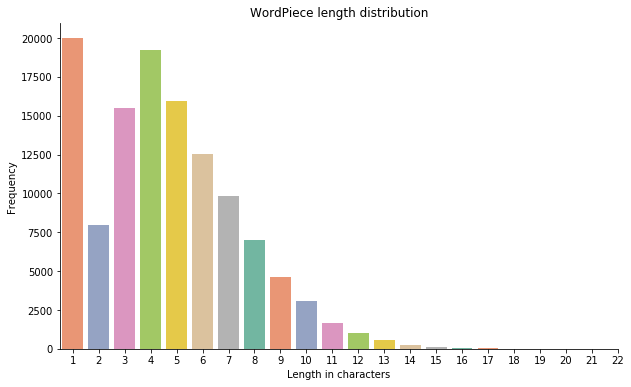

In [6]:
b = bert_vocab[bert_vocab.is_reserved==False]
with sns.plotting_context(font_scale=3):
    fig, ax = plt.subplots(1, figsize=(10, 6))
    sns.countplot(b.token_len, palette="Set2", ax=ax)
    sns.despine()
    ax.set_title("WordPiece length distribution")
    ax.set_xlabel("Length in characters")
    ax.set_ylabel("Frequency")
    ax.set_xlim(0.5, 22)
    fig.savefig("fig/bert_vocab_len_dist.png", bbox_to_inches='tight')

In [7]:
def to_markdown_table(df):
    out = []
    # header
    header_col = "| {} |".format(" | ".join(df.columns))
    out.append(header_col)
    # separator
    sep_col = "| {} |".format(" | ".join("-----" for _ in df.columns))
    out.append(sep_col)
    for row in df.iterrows():
        table_row = "| {} |".format(
            " | ".join(str(r) for r in row[1])
        )
        out.append(table_row)
    return "\n".join(out) + "\n"

In [8]:
h = bert_vocab[bert_vocab.is_reserved==False].sort_values('token_len', ascending=False)[['token', 'token_len']].head(20)
h = pd.concat((h.iloc[:10].reset_index(), h.iloc[10:].reset_index()), axis=1).iloc[:, [1, 2, 4, 5]]
h = h.rename(columns={"token_len": "length"})
with open("fig/longest_bert_tokens.tsv", "w") as f:
    f.write(to_markdown_table(h))

In [9]:
b[(b.token_len==1) & (b.is_continuation==False)].token.nunique()

9997

In [10]:
b[(b.token_len==1)].token.nunique()

19994

In [11]:
ascii_re = r'^[{}]+$'.format(re.escape(string.ascii_letters))
number_re = r'^[0-9]+$'

bert_vocab['ascii'] = bert_vocab.token.str.match(ascii_re)
bert_vocab['digit'] = bert_vocab.token.str.match(number_re)

In [12]:
unicode_ranges = pd.read_table("unicode_ranges.txt", names=["start", "end", "range_name"],
                               quoting=3, na_filter=False, index_col="range_name")
unicode_ranges.start = unicode_ranges.start.apply(lambda x: int(x, 16))
unicode_ranges.end = unicode_ranges.end.apply(lambda x: int(x, 16))
unicode_ranges.head()

,start,end
range_name,,
Basic Latin,0,127
C1 Controls and Latin-1 Supplement,128,255
Latin Extended-A,256,383
Latin Extended-B,384,591
IPA Extensions,592,687


In [13]:
# Japanese Hiragana Unicode range
start = 0x3040
end = 0x309f

# match one or more Hiragana characters
pattern = r'[\U{0:08X}-\U{1:08X}]+'.format(start, end)
print(pattern)
hiragana_re = re.compile(pattern)
print(hiragana_re.match("abc"))
print(hiragana_re.match("ひらがな"))

[\U00003040-\U0000309F]+
None
<re.Match object; span=(0, 4), match='ひらがな'>


In [14]:
start = 0x3040
end = 0x309f

hiragana_re = re.compile(r'^[\U{0:08X}-\U{1:08X}\d]*'
                         r'[\U{0:08X}-\U{1:08X}]+'
                         r'[\U{0:08X}-\U{1:08}\d]*$'.format(start, end))

print(hiragana_re.match("a"))
print(hiragana_re.match("1"))
print(hiragana_re.match("お1"))
print(hiragana_re.match("1お"))
print(hiragana_re.match("おお12お"))
print(hiragana_re.match("ひらがな"))

None
None
<re.Match object; span=(0, 2), match='お1'>
<re.Match object; span=(0, 2), match='1お'>
<re.Match object; span=(0, 5), match='おお12お'>
<re.Match object; span=(0, 4), match='ひらがな'>


In [15]:
print(chr(12362))

お


In [16]:
all_ranges = list(unicode_ranges.index)

cjk_ranges = [r for r in all_ranges if "CJK" in r]

macro_ranges = {
    'ascii': ["Basic Latin"],
    'latin': [r for r in all_ranges if "Latin" in r],
    'cyrillic': [r for r in all_ranges if "Cyrillic" in r],
    'cjk': cjk_ranges,
    'cjk+kana': cjk_ranges + ["Hiragana", "Katakana"],
    'kana': ["Hiragana", "Katakana"],
    'korean': [r for r in all_ranges if "Hangul" in r],
    'arabic': [r for r in all_ranges if "Arabic" in r],
    'hebrew': ['Hebrew'],
    'indian': ['Devanagari', 'Bengali/Assamese', 'Telugu', 'Tamil', 'Kannada', 'Malayalam', 'Gurmukhi',
              'Gujarati', 'Sinhala'],
    'thai': ['Thai'],
    'georgian': ['Georgian'],
    'armenian': ['Armenian'],
    'greek': ['Greek/Coptic', 'Greek Extended'],
    'myanmar': ['Myanmar'],
    'tibetan': ['Tibetan'],
    'mongolian': ['Mongolian'],
    'misc': ['Halfwidth and Fullwidth Forms', 'Superscripts and Subscripts',
       'Mathematical Operators', 'Phonetic Extensions', 'IPA Extensions',
       'General Punctuation', 'Miscellaneous Symbols', 'Geometric Shapes',
       'Spacing Modifier Letters', 'Box Drawing', 'Arrows',
       'Combining Diacritical Marks', 'Small Form Variants', 'Number Forms',
       'Letterlike Symbols', 'Enclosed Alphanumerics',
       'Currency Symbols', 'Miscellaneous Mathematical Symbols-A',
       'Miscellaneous Technical', 'Block Elements', 'Dingbats'],
}

def create_macro_regex(macro_range, include_digits=True):
    char_ranges = []
    for category in macro_range:
        start = int(unicode_ranges.loc[category, "start"])
        end = int(unicode_ranges.loc[category, "end"])
        char_ranges.append(r'\U{0:08x}-\U{1:08x}'.format(start, end))
    if include_digits:
        return re.compile(r'^(##)?([{0}]+[\d{0}]*)|([\d{0}]*[{0}]+)$'.format(''.join(char_ranges)))
    return re.compile(r'^(##)?[{}]+$'.format(''.join(char_ranges)))
        
for lang, ranges in macro_ranges.items():
    bert_vocab[lang] = bert_vocab.token.str.match(create_macro_regex(ranges))

In [17]:
b = bert_vocab[list(macro_ranges.keys())].agg(['sum', 'mean']).T.sort_values('mean', ascending=False).reset_index()
b['sum'] = b['sum'].astype(int)
b['%'] = (b['mean'] * 100).round(2)
b = b.rename(columns={'index': 'script'})
b

,script,sum,mean,%
0,latin,93495,0.782077,78.21
1,ascii,92327,0.772307,77.23
2,cjk+kana,14932,0.124905,12.49
3,cyrillic,13782,0.115285,11.53
4,cjk,13601,0.113771,11.38
5,indian,6545,0.054748,5.47
6,arabic,4873,0.040762,4.08
7,korean,3273,0.027378,2.74
8,hebrew,2482,0.020762,2.08
9,greek,1566,0.013099,1.31


In [18]:
with open("fig/coverate_table.txt", "w") as f:
    f.write(to_markdown_table(b[['script', 'sum', '%']]))

In [19]:
for r1 in unicode_ranges.iterrows():
    r1_set = set(range(r1[1].start, r1[1].end+1))
    for r2 in unicode_ranges.iterrows():
        if r1[0] == r2[0]:
            continue
        r2_set = set(range(r2[1].start, r2[1].end+1))
        if len(r1_set & r2_set) > 0:
            print(r1[0], r2[0], len(r1_set & r2_set))

Malayalam Sinhala 128
Sinhala Malayalam 128


In [20]:
df = pd.DataFrame({'category': k, 'ranges': ", ".join(sorted(v))} for k, v in macro_ranges.items())
df.to_csv("fig/macro_unicode_ranges.txt", index=False, sep="\t")

## Char range coverage

In [21]:
alphabet = set()
vocab = set()
cont_vocab = set()

In [22]:
for token in bert_vocab[bert_vocab.is_reserved==False].token:
    if token.startswith('##'):
        cont_vocab.add(token[2:])
    else:
        vocab.add(token)
    alphabet |= set(token)

In [23]:
len(alphabet - vocab), len(vocab), len(alphabet)

(0, 75835, 9998)

### All characters in BERT are printable

In [24]:
for c in alphabet:
    if unicodedata.category(c) == "Cc":
        print(c)

In [25]:
def get_coverage_stats(row):
    start = int(row['start'])
    end = int(row['end'])
    in_alpha = 0
    sum_c = 0
    for c in range(start, end+1):
        if unicodedata.category(chr(c)) == 'Cc':
            continue
        sum_c += 1
        if chr(c) in alphabet:
            in_alpha += 1
    row['printable_sum'] = sum_c
    row['in_bert'] = in_alpha
    return row

unicode_ranges = unicode_ranges.apply(get_coverage_stats, axis=1)

In [26]:
unicode_ranges['in_bert_ratio'] = unicode_ranges['in_bert'] / unicode_ranges['printable_sum']

In [27]:
unicode_ranges.sort_values('in_bert_ratio', ascending=False)

,start,end,printable_sum,in_bert,in_bert_ratio
range_name,,,,,
Basic Latin,0,127,95,93,0.978947
C1 Controls and Latin-1 Supplement,128,255,96,87,0.906250
Katakana,12448,12543,96,86,0.895833
Armenian,1328,1423,96,84,0.875000
Hiragana,12352,12447,96,81,0.843750
Superscripts and Subscripts,8304,8351,48,33,0.687500
Latin Extended-A,256,383,128,87,0.679688
Devanagari,2304,2431,128,86,0.671875
Thai,3584,3711,128,77,0.601562


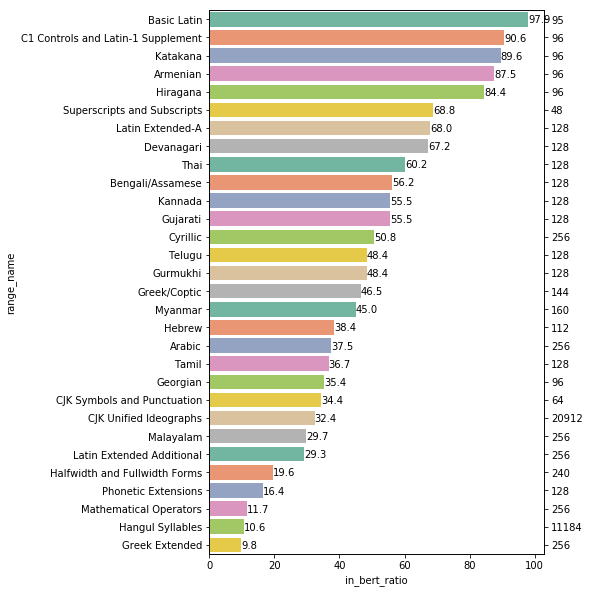

In [28]:
e = unicode_ranges[unicode_ranges.in_bert > 20].sort_values('in_bert_ratio', ascending=False)
fig, ax = plt.subplots(1, figsize=(6, 10))

sns.barplot(x=e.in_bert_ratio, y=e.index, ax=ax, palette="Set2")
ax2 = ax.twinx()
ax2.set_yticklabels(e.printable_sum)
#ax.grid(True, axis='y')
ax2.set_ylim(ax.get_ylim())
ax.set_xticklabels(list(range(0, 101, 20)))
_ = ax2.set_yticks(ax.get_yticks())

for i, p in enumerate(ax.patches):
    ax.text(p.get_width(), p.get_y()+.6, round(e.iloc[i].in_bert_ratio*100, 1))

# Universal Dependency coverage

In [29]:
bert_langs = ["Afrikaans", "Albanian", "Arabic", "Aragonese", "Armenian", "Asturian", "Azerbaijani",
    "Bashkir", "Basque", "Bavarian", "Belarusian", "Bengali", "Bishnupriya Manipuri", "Bosnian",
    "Breton", "Bulgarian", "Burmese", "Catalan", "Cebuano", "Chechen", 
              "Chinese (Simplified)", "Chinese (Traditional)",
    "Chinese", "Chuvash", "Croatian", "Czech", "Danish", "Dutch", "English",
    "Estonian", "Finnish", "French", "Galician", "Georgian", "German", "Greek", "Gujarati",
    "Haitian", "Hebrew", "Hindi", "Hungarian", "Icelandic", "Ido", "Indonesian", "Irish",
    "Italian", "Japanese", "Javanese", "Kannada", "Kazakh", "Kirghiz", "Korean", "Latin",
    "Latvian", "Lithuanian", "Lombard", "Low Saxon", "Luxembourgish", "Macedonian", "Malagasy",
    "Malay", "Malayalam", "Marathi", "Minangkabau", "Nepali", "Newar", "Norwegian (Bokmal)",
    "Norwegian (Nynorsk)",
    "Occitan", "Persian", "Piedmontese", "Polish", "Portuguese",
    "Punjabi", "Romanian", "Russian", "Scots", "Serbian", "Serbo-Croatian", "Sicilian", "Slovak",
    "Slovenian", "South Azerbaijani", "Spanish", "Sundanese", "Swahili", "Swedish", "Tagalog",
    "Tajik", "Tamil", "Tatar", "Telugu", "Turkish", "Ukrainian", "Urdu", "Uzbek", "Vietnamese",
    "Volapük", "Waray-Waray", "Welsh", "West Frisian", "Western Punjabi", "Yoruba",
    ]

In [30]:
bert_stats = pd.read_table("bert_tokenizer_stats.tsv", index_col=0)

In [31]:
def get_language(filename):
    lang = filename.split("/")[-2][3:].split("-")[0]
    if lang == 'Norwegian':
        if 'Nynorsk' in filename:
            return 'Norwegian (Nynorsk)'
        else:
            return 'Norwegian (Bokmal)'
    elif lang == 'Chinese':
        if 'CFL' in filename or 'PUD' in filename:
            return 'Chinese (Simplified)'
        else:
            return 'Chinese (Traditional)'
    return lang

In [32]:
bert_stats['language'] = bert_stats.filename.apply(get_language)
bert_stats['fertility'] = bert_stats['bert_token_no'] / bert_stats['token_no']
bert_stats.head()

,avg_bert_gain,bert_len_1,bert_len_10,bert_len_11,bert_len_12,bert_len_13,bert_len_14,bert_len_15,bert_len_16,bert_len_17,...,token_len_87,token_len_89,token_len_9,token_len_92,token_len_95,token_len_97,token_len_98,token_no,language,fertility
0,0.0,9010,144.0,65.0,62.0,18.0,5.0,4.0,NaN,NaN,...,NaN,NaN,1439.0,NaN,NaN,NaN,NaN,33894,Afrikaans,1.658789
1,0.0,1339,19.0,4.0,5.0,6.0,NaN,NaN,NaN,NaN,...,NaN,NaN,271.0,NaN,NaN,NaN,NaN,5317,Afrikaans,1.602595
2,0.0,2675,27.0,6.0,21.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,389.0,NaN,NaN,NaN,NaN,10065,Afrikaans,1.659314
3,0.0,6159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,67.0,NaN,NaN,NaN,NaN,1852,Akkadian,4.946004
4,0.0,151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,12682,Amharic,0.415313


In [33]:
bert_langs = set(bert_langs)
ud_langs = set(bert_stats.language.unique())

In [34]:
common_langs = bert_langs & ud_langs
with open("common_langs.txt", 'w') as f:
    f.write("\n".join(sorted(common_langs)))

In [35]:
bert_stats[bert_stats.language.isin(common_langs)].groupby('language')[['token_no', 'sentence_no']].sum().sort_values('sentence_no').head()

,token_no,sentence_no
language,,
Tagalog,292,55
Yoruba,2666,100
Lithuanian,5356,263
Belarusian,8106,393
Marathi,4180,466


In [36]:
len(bert_langs & ud_langs)

54

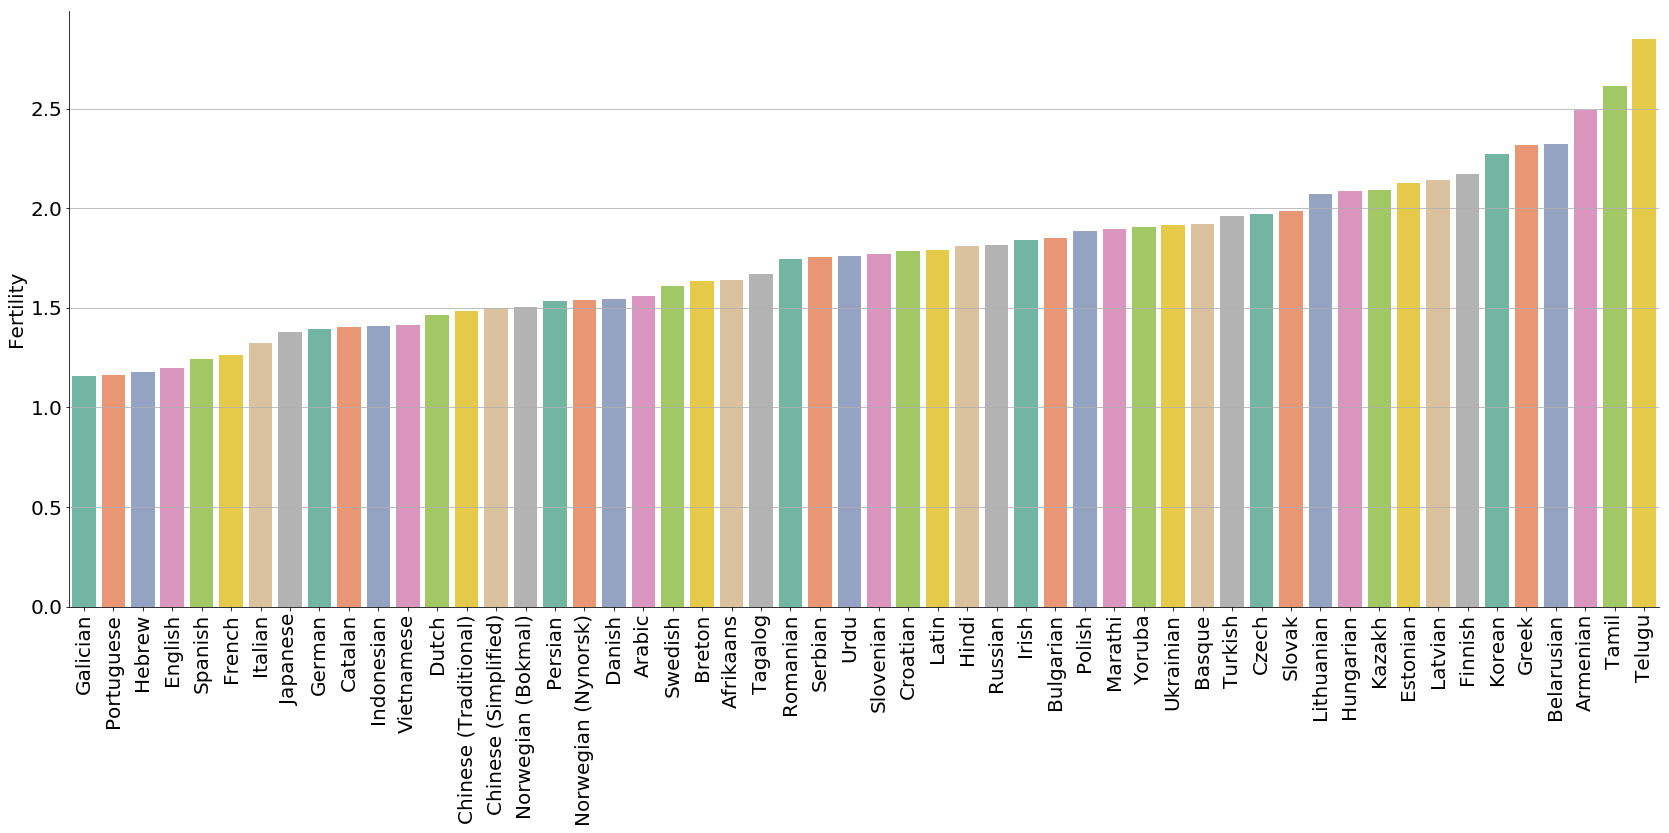

In [37]:
fertility = bert_stats[bert_stats.language.isin(common_langs)].groupby('language').fertility.mean().sort_values().to_frame()
fig, ax = plt.subplots(1, figsize=(24, 12))

sns.barplot(x=fertility.index, y=fertility.fertility, ax=ax, palette="Set2")
plt.xticks(rotation=90)
ax.grid(True, axis='y')
ax.set_xlabel("")
ax.set_ylabel("Fertility", fontsize=20)
ax.tick_params(labelsize=20)
sns.despine()
fig.subplots_adjust(left=0.05, right=0.97, bottom=0.26, top=0.95)
plt.savefig("fig/bert_fertility.png") #, bbox_to_anchor='tight')

In [38]:
fertility.iloc[[0, 1, 2, -3, -2, -1]]

,fertility
language,
Galician,1.160332
Portuguese,1.164286
Hebrew,1.179777
Armenian,2.490505
Tamil,2.614693
Telugu,2.848632


In [39]:
bert_stats['continuation_ratio'] = bert_stats.continuation / bert_stats.bert_token_no
continuation = bert_stats[bert_stats.language.isin(common_langs)].groupby('language').continuation_ratio.mean().sort_values().to_frame()
continuation.iloc[[0, 1, 2, -3, -2, -1]]

,continuation_ratio
language,
Chinese (Traditional),0.002782
Chinese (Simplified),0.003380
English,0.131201
Armenian,0.591341
Telugu,0.647466
Tamil,0.673393


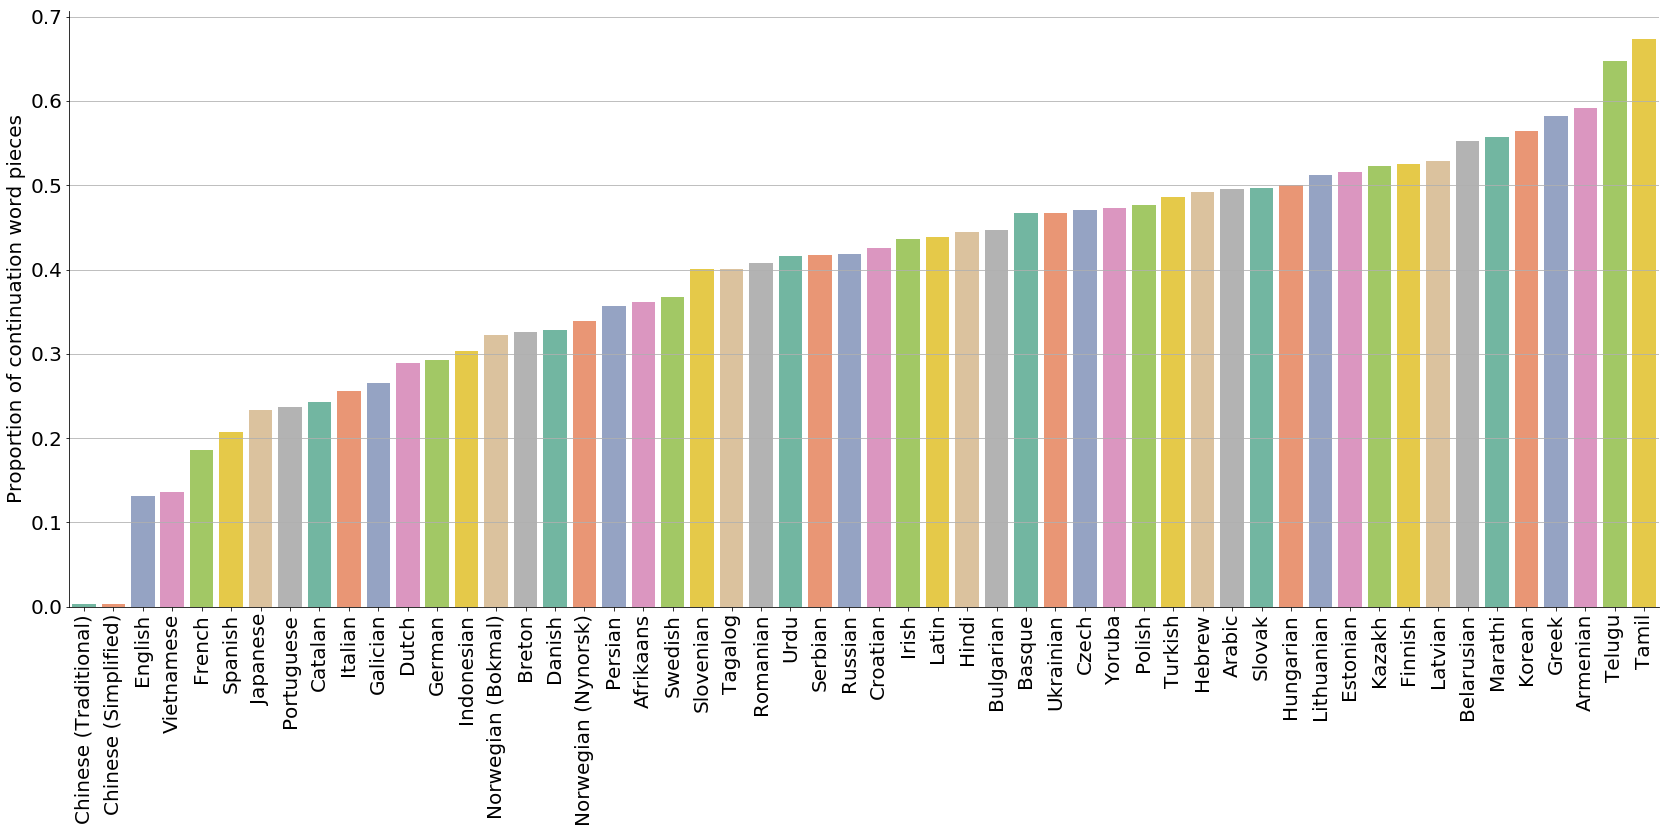

In [40]:
fig, ax = plt.subplots(1, figsize=(24, 12))

sns.barplot(x=continuation.index, y=continuation.continuation_ratio, ax=ax, palette="Set2")
plt.xticks(rotation=90)
ax.grid(True, axis='y')
ax.set_xlabel("")
ax.set_ylabel("Proportion of continuation word pieces", fontsize=20)
ax.tick_params(labelsize=20)
sns.despine()
fig.subplots_adjust(left=0.05, right=0.97, bottom=0.26, top=0.95)
plt.savefig("fig/bert_continuation_ratio.png") #, bbox_to_anchor='tight')

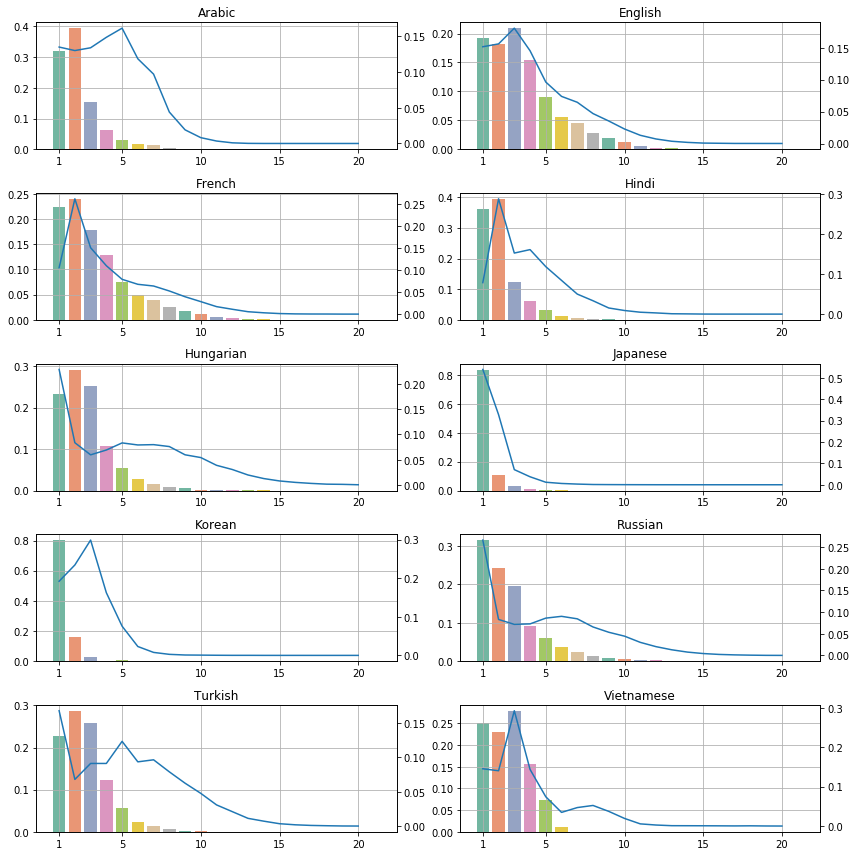

In [41]:
bert_num_cols = list(c for c in bert_stats.columns if c.startswith('bert_len_'))
token_num_cols = list(c for c in bert_stats.columns if c.startswith('token_len_'))

cherry_languages = sorted(["English", "Hungarian", "French", "Korean", "Arabic", "Japanese",
                    "Russian", "Hindi", "Turkish", "Vietnamese"])
languages = cherry_languages
size_x = 12
size_y = 12 / 10 * len(languages)


with sns.plotting_context(font_scale=2):
    
    fig, ax = plt.subplots(len(languages) // 2, 2, figsize=(size_x, size_y))
    for li, language in enumerate(languages):
        if li >= ax.size:
            break
        i = li // ax.shape[1]
        j = li % ax.shape[1] 
        d = bert_stats[bert_stats.language==language][bert_num_cols].fillna(0)
        d = d.div(d.sum(axis=1), axis=0).mean()
        d.index = d.index.str[len("bert_len_"):].astype(int)
        if 0 in d.index:
            d = d.drop(index=0)
        pl = sns.barplot(x=d.index, y=d, ax=ax[i, j], palette="Set2")
        ax[i, j].set_title("{}".format(language.replace("_", " ")))

        max_x = int(ax[i, j].get_xlim()[1])
        tick_positions = [0] + list(range(4, max_x+1, 5))
        tick_labels = [1] + list(range(5, max_x+1, 5))
        ax[i, j].xaxis.set_major_locator(ticker.FixedLocator(tick_positions))
        ax[i, j].set(xticklabels=tick_labels)
        ax[i, j].grid(True)

        # token dist
        dax = ax[i, j].twinx()
        d = bert_stats[bert_stats.language==language][token_num_cols].fillna(0)
        d = d.div(d.sum(axis=1), axis=0).mean()
        d.index = d.index.str[len("token_len_"):].astype(int)
        d = d[d.index < 21]
        pl = sns.lineplot(x=d.index-1, y=d, ax=dax, palette="Set2")
        plt.tight_layout(w_pad=0.5)

    plt.savefig("fig/bert_token_len_short.png", bbox_inches='tight')

In [42]:
bert_num_cols = list(c for c in bert_stats.columns if c.startswith('bert_len_'))
token_num_cols = list(c for c in bert_stats.columns if c.startswith('token_len_'))

languages = list(fertility.sort_values('fertility').index)
size_x = 12
size_y = 55

with sns.plotting_context(font_scale=2):
    
    fig, ax = plt.subplots(len(languages) // 2, 2, figsize=(size_x, size_y))
    for li, language in enumerate(languages):
        if li >= ax.size:
            break
        i = li // ax.shape[1]
        j = li % ax.shape[1] 
        d = bert_stats[bert_stats.language==language][bert_num_cols].fillna(0)
        d = d.div(d.sum(axis=1), axis=0).mean()
        d.index = d.index.str[len("bert_len_"):].astype(int)
        if 0 in d.index:
            d = d.drop(index=0)
        pl = sns.barplot(x=d.index, y=d, ax=ax[i, j], palette="Set2")
        ax[i, j].set_title("{}".format(language.replace("_", " ")))

        max_x = int(ax[i, j].get_xlim()[1])
        tick_positions = [0] + list(range(4, max_x+1, 5))
        tick_labels = [1] + list(range(5, max_x+1, 5))
        ax[i, j].xaxis.set_major_locator(ticker.FixedLocator(tick_positions))
        ax[i, j].set(xticklabels=tick_labels)
        ax[i, j].grid(True)

        # token dist
        dax = ax[i, j].twinx()
        d = bert_stats[bert_stats.language==language][token_num_cols].fillna(0)
        d = d.div(d.sum(axis=1), axis=0).mean()
        d.index = d.index.str[len("token_len_"):].astype(int)
        d = d[d.index < 21]
        pl = sns.lineplot(x=d.index-1, y=d, ax=dax, palette="Set2")
        plt.tight_layout(w_pad=0.5)

    plt.savefig("fig/bert_token_len_full.png", bbox_inches='tight')
    plt.close(fig)

In [43]:
bert_num_cols = list(c for c in bert_stats.columns if c.startswith('bert_len_'))
token_num_cols = list(c for c in bert_stats.columns if c.startswith('token_len_'))

languages = sorted(common_langs)
size_x = 12
size_y = 55

with sns.plotting_context(font_scale=2):
    
    fig, ax = plt.subplots(len(languages) // 2, 2, figsize=(size_x, size_y))
    for li, language in enumerate(languages):
        if li >= ax.size:
            break
        i = li // ax.shape[1]
        j = li % ax.shape[1] 
        d = bert_stats[bert_stats.language==language][bert_num_cols].fillna(0)
        d = d.div(d.sum(axis=1), axis=0).mean()
        d.index = d.index.str[len("bert_len_"):].astype(int)
        if 0 in d.index:
            d = d.drop(index=0)
        pl = sns.barplot(x=d.index, y=d, ax=ax[i, j], palette="Set2")
        ax[i, j].set_title("{}".format(language.replace("_", " ")))

        max_x = int(ax[i, j].get_xlim()[1])
        tick_positions = [0] + list(range(4, max_x+1, 5))
        tick_labels = [1] + list(range(5, max_x+1, 5))
        ax[i, j].xaxis.set_major_locator(ticker.FixedLocator(tick_positions))
        ax[i, j].set(xticklabels=tick_labels)
        ax[i, j].grid(True)

        # token dist
        dax = ax[i, j].twinx()
        d = bert_stats[bert_stats.language==language][token_num_cols].fillna(0)
        d = d.div(d.sum(axis=1), axis=0).mean()
        d.index = d.index.str[len("token_len_"):].astype(int)
        d = d[d.index < 21]
        pl = sns.lineplot(x=d.index-1, y=d, ax=dax, palette="Set2")
        plt.tight_layout(w_pad=0.5)

    plt.savefig("fig/bert_token_len_full_fertility_sorted.png", bbox_inches='tight')
    plt.close(fig)

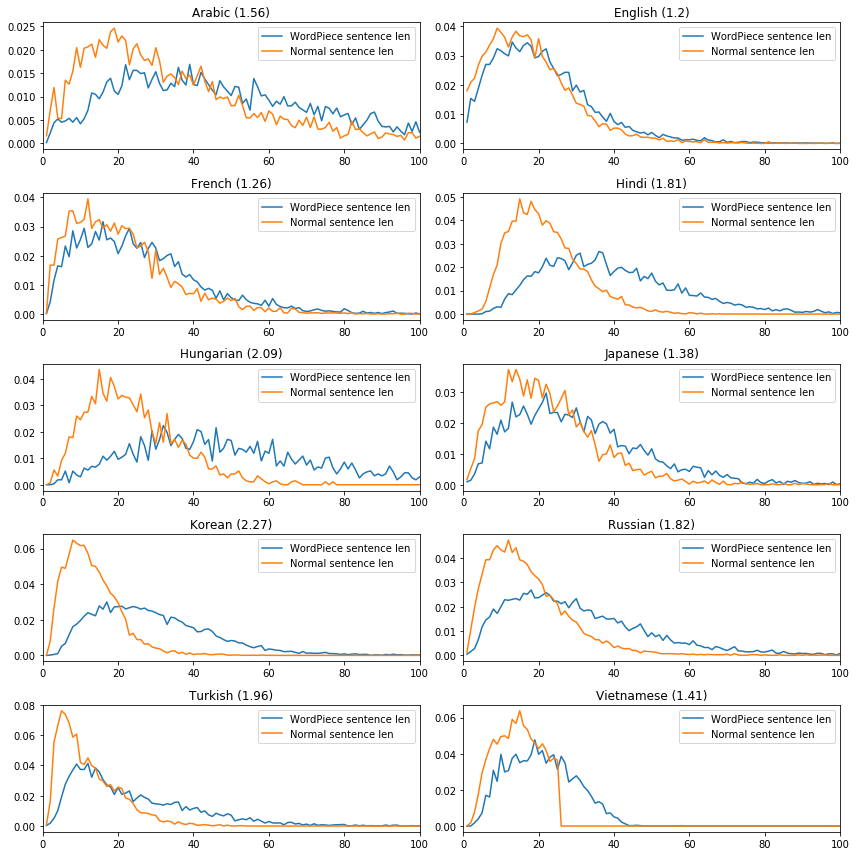

In [44]:
bert_sent_cols = list(c for c in bert_stats.columns if c.startswith('bert_sent_len_'))
sent_cols = list(c for c in bert_stats.columns if c.startswith('sent_len_'))

languages = cherry_languages
size_x = 12
size_y = 12 / 10 * len(languages)

with sns.plotting_context(font_scale=2):
    
    fig, ax = plt.subplots(len(languages) // 2, 2, figsize=(size_x, size_y))
    for li, language in enumerate(languages):
        if li >= ax.size:
            break
            
        i = li // ax.shape[1]
        j = li % ax.shape[1] 
            
        d = bert_stats[bert_stats.language==language][bert_sent_cols].fillna(0)
        d = d.div(d.sum(axis=1), axis=0).mean()
        d.index = d.index.str[len("bert_sent_len_"):].astype(int)
        sns.lineplot(x=d.index, y=d, palette="Set2", ax=ax[i, j])

        ax[i, j].set_title("{} ({})".format(language.replace("_", " "), round(fertility.loc[language, "fertility"], 2)))
        d = bert_stats[bert_stats.language==language][sent_cols].fillna(0)
        d = d.div(d.sum(axis=1), axis=0).mean()
        d.index = d.index.str[len("sent_len_"):].astype(int)
        sns.lineplot(x=d.index, y=d, palette="Set2", ax=ax[i, j])

        ax[i, j].legend(['WordPiece sentence len', 'Normal sentence len'])
        ax[i, j].set_xlim(0, 100)
        
        plt.tight_layout(w_pad=0.5)

    plt.savefig("fig/bert_sent_len_short.png", bbox_inches='tight')

In [45]:
bert_sent_cols = list(c for c in bert_stats.columns if c.startswith('bert_sent_len_'))
sent_cols = list(c for c in bert_stats.columns if c.startswith('sent_len_'))

languages = list(fertility.sort_values('fertility').index)

with sns.plotting_context(font_scale=2):
    
    fig, ax = plt.subplots(len(languages) // 2, 2, figsize=(12, 55))
    for li, language in enumerate(languages):
        if li >= ax.size:
            break
            
        i = li // ax.shape[1]
        j = li % ax.shape[1] 
            
        d = bert_stats[bert_stats.language==language][bert_sent_cols].fillna(0)
        d = d.div(d.sum(axis=1), axis=0).mean()
        d.index = d.index.str[len("bert_sent_len_"):].astype(int)
        sns.lineplot(x=d.index, y=d, palette="Set2", ax=ax[i, j])

        ax[i, j].set_title("{} ({})".format(language.replace("_", " "), round(fertility.loc[language, "fertility"], 2)))
        d = bert_stats[bert_stats.language==language][sent_cols].fillna(0)
        d = d.div(d.sum(axis=1), axis=0).mean()
        d.index = d.index.str[len("sent_len_"):].astype(int)
        sns.lineplot(x=d.index, y=d, palette="Set2", ax=ax[i, j])

        ax[i, j].legend(['WordPiece sentence len', 'Normal sentence len'])
        ax[i, j].set_xlim(0, 100)
        
        plt.tight_layout(w_pad=0.5)

    plt.savefig("fig/bert_sent_len_full.png", bbox_inches='tight')
    plt.close(fig)

In [46]:
bert_sent_cols = list(c for c in bert_stats.columns if c.startswith('bert_sent_len_'))
sent_cols = list(c for c in bert_stats.columns if c.startswith('sent_len_'))

languages = sorted(common_langs)

with sns.plotting_context(font_scale=2):
    
    fig, ax = plt.subplots(len(languages) // 2, 2, figsize=(12, 55))
    for li, language in enumerate(languages):
        if li >= ax.size:
            break
            
        i = li // ax.shape[1]
        j = li % ax.shape[1] 
            
        d = bert_stats[bert_stats.language==language][bert_sent_cols].fillna(0)
        d = d.div(d.sum(axis=1), axis=0).mean()
        d.index = d.index.str[len("bert_sent_len_"):].astype(int)
        sns.lineplot(x=d.index, y=d, palette="Set2", ax=ax[i, j])

        ax[i, j].set_title("{} ({})".format(language.replace("_", " "), round(fertility.loc[language, "fertility"], 2)))
        d = bert_stats[bert_stats.language==language][sent_cols].fillna(0)
        d = d.div(d.sum(axis=1), axis=0).mean()
        d.index = d.index.str[len("sent_len_"):].astype(int)
        sns.lineplot(x=d.index, y=d, palette="Set2", ax=ax[i, j])

        ax[i, j].legend(['WordPiece sentence len', 'Normal sentence len'])
        ax[i, j].set_xlim(0, 100)
        
        plt.tight_layout(w_pad=0.5)

    plt.savefig("fig/bert_sent_len_full_fertility_sorted.png", bbox_inches='tight')
    plt.close(fig)